# AFL Supercoach Prediction Model
Selecting your supercoach team is hard... this model is designed as a tool to assist supercoach users in selecting their team week-to-week.

This model uses rolling stats, opposition data, and past injury data to provide a predicted score for matches.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 30)

### Get Footywire Data
This data was scraped using the fitzRoy R Package https://github.com/jimmyday12/fitzRoy.

For this code, refer to fitzroy.R

In [2]:
# Get footywire match data with a row for each player
df_footywire_data = pd.read_csv(r'inputs/footywire_player_matches.csv', index_col=0)
# Drop duplicates
df_footywire_data = df_footywire_data.drop_duplicates()
df_footywire_data.tail(5)

,Date,Season,Round,Venue,Player,Team,Opposition,Status,Match_id,CP,UP,ED,DE,CM,GA,MI5,One.Percenters,BO,TOG,K,HB,D,M,G,B,T,HO,GA1,I50,CL,CG,R50,FF,FA,AF,SC,CCL,SCL,SI,MG,TO,ITC,T5
90416,2019-09-28,2019,Grand Final,MCG,Harrison Himmelberg,GWS,Richmond,Away,9927,3,9,7,58.3,1,0,2,4,0,92,9,3,12,7,1,1,1,2,0,2,0,3,0,1,1,65,51,0.0,0.0,3.0,153.0,4.0,2.0,1.0
90417,2019-09-28,2019,Grand Final,MCG,Samuel Reid,GWS,Richmond,Away,9927,5,6,8,66.7,0,0,0,4,0,96,5,7,12,2,0,0,3,0,0,0,1,2,1,0,0,47,55,0.0,1.0,1.0,97.0,2.0,5.0,0.0
90418,2019-09-28,2019,Grand Final,MCG,Adam Kennedy,GWS,Richmond,Away,9927,4,8,9,81.8,0,0,0,1,0,71,5,6,11,4,0,0,4,0,0,2,1,0,0,1,0,56,55,0.0,1.0,1.0,121.0,0.0,5.0,1.0
90419,2019-09-28,2019,Grand Final,MCG,Shane Mumford,GWS,Richmond,Away,9927,8,2,7,70.0,0,0,0,4,0,75,2,8,10,0,0,0,1,15,0,1,2,2,1,1,0,42,62,1.0,1.0,0.0,0.0,1.0,2.0,0.0
90420,2019-09-28,2019,Grand Final,MCG,Jeremy Finlayson,GWS,Richmond,Away,9927,1,1,1,100.0,0,0,0,3,0,63,1,0,1,1,0,0,1,1,0,0,1,1,0,0,1,8,7,1.0,0.0,0.0,26.0,1.0,0.0,1.0


### Get Fanfooty Data
This data was scraped from http://www.fanfooty.com.au/

In [3]:
# Get Fanfooty match data with a row for each player (including match notes and injury tags)
df_fanfooty_player_raw = pd.read_csv(r'inputs/fanfooty_raw.csv', low_memory=False)
df_fanfooty_player_raw.tail(5)

,Fanfooty Match ID,Round,Year,Player ID,First Name,Surname,Team,null,DT,SC,null2,null3,null4,Kicks,Handballs,Marks,Tackles,Hitouts,Frees for,Frees against,Goals,Behinds,Not sure,Tag,Tag Notes,Tag 2,Tag 2 Notes,null5,null6,null7,null8,Position,Jumper Number,null9,null10,null11,DT own %,SC own %,AF own %,null12,AF Breakeven,null13,Contested Possessions,Clearances,Clangers,Disposal efficiency,Time on ground
88570,http://live.fanfooty.com.au/game/matchcentre.h...,GF,2019,261374,Sam J.,Reid,WS,4,47,55.0,40,36,51,5,7,2,3,0,0,0,0,0,Full Time,utility,%D and %M with %T... Mostly in defence,NaN,NaN,0.0,NaN,0.0,NaN,Forward,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,5.0,1.0,2.0,66.0,96.0
88571,http://live.fanfooty.com.au/game/matchcentre.h...,GF,2019,280762,Shane,Mumford,WS,8,42,62.0,38,38,48,2,8,0,1,15,1,0,0,0,Full Time,ruck,%O including %B... First ruck,NaN,NaN,0.0,NaN,0.0,NaN,Ruck,41.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,8.0,2.0,2.0,70.0,75.0
88572,http://live.fanfooty.com.au/game/matchcentre.h...,GF,2019,290675,Daniel,Lloyd,WS,6,38,54.0,23,34,52,6,9,1,1,0,0,2,0,1,Full Time,wing,%D and %s... Playing a half forward role,NaN,NaN,0.0,NaN,0.0,NaN,Midfielder,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,8.0,2.0,4.0,66.0,76.0
88573,http://live.fanfooty.com.au/game/matchcentre.h...,GF,2019,271015,Matthew,de Boer,WS,3,31,21.0,16,31,46,6,6,3,0,0,0,3,0,1,Full Time,tagger,%O and %M plus %s... not helped by %F... Doing...,NaN,NaN,0.0,NaN,0.0,NaN,Midfielder,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,6.0,66.0,79.0
88574,http://live.fanfooty.com.au/game/matchcentre.h...,GF,2019,298111,Jeremy,Finlayson,WS,0,8,7.0,8,7,10,1,0,1,1,1,0,1,0,0,Full Time,spearhead,Starting forward,NaN,NaN,0.0,NaN,0.0,NaN,Back,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,1.0,1.0,100.0,63.0


### Identify when players were injured during a match
Fanfooty has amazing "tags" that can be used to identify when a player has been injured during a match

If they have certain tags (e.g. concussed) and score below 80 supercoach points, they are judged as injured.

In [4]:
# Identify when a player is injured
injured_tags = [
    'sore',
    'injured',
    'longterminjured',
    'concussed',
    'heart'
]

def get_injured_status(row):
    if (row['Tag'] in injured_tags or row['Tag 2'] in injured_tags) and row['SC'] < 80:
        return True
    else:
        return False

df_fanfooty_player_raw['Injured'] = df_fanfooty_player_raw.apply(lambda row: get_injured_status(row), axis=1)

### Create identifiers to allow for linking between footywire and fanfooty datasets

In [5]:
# Create year, round, and player identifier to link with footywire data
df_fanfooty_player_raw['year_round_player_id'] = df_fanfooty_player_raw['Year'].astype(str) + "_" + df_fanfooty_player_raw['Round'].astype(str) + "_" + df_fanfooty_player_raw['Player ID'].astype(str)
df_fanfooty_player_raw

,Fanfooty Match ID,Round,Year,Player ID,First Name,Surname,Team,null,DT,SC,null2,null3,null4,Kicks,Handballs,Marks,Tackles,Hitouts,Frees for,Frees against,Goals,Behinds,Not sure,Tag,Tag Notes,Tag 2,Tag 2 Notes,null5,null6,null7,null8,Position,Jumper Number,null9,null10,null11,DT own %,SC own %,AF own %,null12,AF Breakeven,null13,Contested Possessions,Clearances,Clangers,Disposal efficiency,Time on ground,Injured,year_round_player_id
0,http://live.fanfooty.com.au/game/matchcentre.h...,R4,2010,990020,Andrew,Embley,WC,30,111,98.0,144,79,112,20,8,1,6,1,1,0,1,0,Full Time,gun,Dempsey going with him... %s from %O and %T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2010_R4_990020
1,http://live.fanfooty.com.au/game/matchcentre.h...,R4,2010,230254,Adam,Selwood,WC,50,107,107.0,143,79,108,10,9,4,11,0,3,2,1,0,Full Time,hot,Tagged by Lonergan... %D and %M with %T plus %s,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2010_R4_230254
2,http://live.fanfooty.com.au/game/matchcentre.h...,R4,2010,200112,Dean,Cox,WC,27,99,118.0,114,88,106,9,10,2,2,30,4,1,1,1,Full Time,news,%H and %P with %s,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2010_R4_200112
3,http://live.fanfooty.com.au/game/matchcentre.h...,R4,2010,240016,Beau,Waters,WC,26,98,84.0,130,79,117,15,13,5,6,0,0,4,0,0,Full Time,news,%P and %M with %F... clangers and FA dampening...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2010_R4_240016
4,http://live.fanfooty.com.au/game/matchcentre.h...,R4,2010,261911,Brad,Ebert,WC,26,94,109.0,121,70,96,12,9,3,6,0,1,0,1,0,Full Time,news,Matched up on Winderlich... %D and %T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2010_R4_261911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88570,http://live.fanfooty.com.au/game/matchcentre.h...,GF,2019,261374,Sam J.,Reid,WS,4,47,55.0,40,36,51,5,7,2,3,0,0,0,0,0,Full Time,utility,%D and %M with %T... Mostly in defence,NaN,NaN,0.0,NaN,0.0,NaN,Forward,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,5.0,1.0,2.0,66.0,96.0,False,2019_GF_261374
88571,http://live.fanfooty.com.au/game/matchcentre.h...,GF,2019,280762,Shane,Mumford,WS,8,42,62.0,38,38,48,2,8,0,1,15,1,0,0,0,Full Time,ruck,%O including %B... First ruck,NaN,NaN,0.0,NaN,0.0,NaN,Ruck,41.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,8.0,2.0,2.0,70.0,75.0,False,2019_GF_280762
88572,http://live.fanfooty.com.au/game/matchcentre.h...,GF,2019,290675,Daniel,Lloyd,WS,6,38,54.0,23,34,52,6,9,1,1,0,0,2,0,1,Full Time,wing,%D and %s... Playing a half forward role,NaN,NaN,0.0,NaN,0.0,NaN,Midfielder,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,8.0,2.0,4.0,66.0,76.0,False,2019_GF_290675
88573,http://live.fanfooty.com.au/game/matchcentre.h...,GF,2019,271015,Matthew,de Boer,WS,3,31,21.0,16,31,46,6,6,3,0,0,0,3,0,1,Full Time,tagger,%O and %M plus %s... not helped by %F... Doing...,NaN,NaN,0.0,NaN,0.0,NaN,Midfielder,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,6.0,66.0,79.0,False,2019_GF_271015


In [6]:
# Get player identification links (refer to footywire-player-ids jupyter notebook)
df_final_player_ids = pd.read_csv('Inputs/final_player_ids_08-02-20.csv')
df_final_player_ids['Player ID'] = df_final_player_ids['Player ID'].astype(str).replace('\.0', '', regex=True)
df_final_player_ids

,Unnamed: 0,Season,Team_footywire,Player,SC_footywire,season_team_name_id,Player ID,Year,Team_fanfooty,Full Name,SC_fanfooty,fuzzy_match_name,fuzzy_season_team_name
0,0,2011,North Melbourne,Aaron Black,33.000000,2011_North Melbourne_Aaron Black,291672,2011.0,North Melbourne,Aaron Black,33.000000,NaN,NaN
1,1,2012,North Melbourne,Aaron Black,49.666667,2012_North Melbourne_Aaron Black,291672,2012.0,North Melbourne,Aaron Black,49.666667,NaN,NaN
2,2,2013,North Melbourne,Aaron Black,76.555556,2013_North Melbourne_Aaron Black,291672,2013.0,North Melbourne,Aaron Black,76.388889,NaN,NaN
3,3,2014,North Melbourne,Aaron Black,56.680000,2014_North Melbourne_Aaron Black,291672,2014.0,North Melbourne,Aaron Black,56.680000,NaN,NaN
4,4,2015,North Melbourne,Aaron Black,42.000000,2015_North Melbourne_Aaron Black,291672,2015.0,North Melbourne,Aaron Black,42.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6511,6511,2017,Sydney,Zak Jones,82.521739,2017_Sydney_Zak Jones,991988,2017.0,Sydney,Zak Jones,82.521739,NaN,NaN
6512,6512,2018,Sydney,Zak Jones,78.473684,2018_Sydney_Zak Jones,991988,2018.0,Sydney,Zak Jones,78.473684,NaN,NaN
6513,6513,2019,Sydney,Zak Jones,85.947368,2019_Sydney_Zak Jones,991988,2019.0,Sydney,Zak Jones,85.705882,NaN,NaN
6514,6514,2011,Western Bulldogs,Zephaniah Skinner,4.000000,2011_Western Bulldogs_Zephaniah Skinner,280442,2011.0,Western Bulldogs,Zephaniah Skinner,4.000000,NaN,NaN


### Ensure consistent naming conventions are used for rounds
e.g. R1 should always be used... convert "Round 1" to "R1"

In [7]:
# Create a column for a standard round name e.g. Grand Final should be GF
round_map_data = {
    "R1": "Round 1",
    "R2": "Round 2",
    "R3": "Round 3",
    "R4": "Round 4",
    "R5": "Round 5",
    "R6": "Round 6",
    "R7": "Round 7",
    "R8": "Round 8",
    "R9": "Round 9",
    "R10": "Round 10",
    "R11": "Round 11",
    "R12": "Round 12",
    "R13": "Round 13",
    "R14": "Round 14",
    "R15": "Round 15",
    "R16": "Round 16",
    "R17": "Round 17",
    "R18": "Round 18",
    "R19": "Round 19",
    "R20": "Round 20",
    "R21": "Round 21",
    "R22": "Round 22",
    "R23": "Round 23",
    "R24": "Round 24",
    "SF": "Semi Final",
    "GF": "Grand Final",
    "PF": "Preliminary Final",
    "QF": "Qualifying Final",
    "EF": "Elimination Final"
}

df_round_mapping = pd.DataFrame.from_dict(round_map_data, orient='index')
df_round_mapping = df_round_mapping.reset_index().rename(columns={'index': 'short_round', 0: 'long_round'})
round_mapping = dict(df_round_mapping[['long_round', 'short_round']].values)
df_footywire_data['short_round'] = df_footywire_data['Round'].map(round_mapping)
df_footywire_data

,Date,Season,Round,Venue,Player,Team,Opposition,Status,Match_id,CP,UP,ED,DE,CM,GA,MI5,One.Percenters,BO,TOG,K,HB,D,M,G,B,T,HO,GA1,I50,CL,CG,R50,FF,FA,AF,SC,CCL,SCL,SI,MG,TO,ITC,T5,short_round
1,2010-03-25,2010,Round 1,MCG,Daniel Connors,Richmond,Carlton,Home,5089,8,15,16,66.7,0,0,0,1,0,69,14,10,24,3,0,0,1,0,0,2,2,4,6,2,0,77,85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1
2,2010-03-25,2010,Round 1,MCG,Daniel Jackson,Richmond,Carlton,Home,5089,11,10,14,60.9,1,0,0,0,0,80,11,12,23,2,0,0,5,0,0,8,5,4,1,2,0,85,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1
3,2010-03-25,2010,Round 1,MCG,Brett Deledio,Richmond,Carlton,Home,5089,7,14,16,76.2,0,0,0,0,0,89,12,9,21,5,1,0,6,0,0,4,3,4,3,1,2,94,93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1
4,2010-03-25,2010,Round 1,MCG,Ben Cousins,Richmond,Carlton,Home,5089,9,10,11,57.9,0,1,0,0,0,69,13,6,19,1,1,0,1,0,1,1,2,3,4,1,0,65,70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1
5,2010-03-25,2010,Round 1,MCG,Trent Cotchin,Richmond,Carlton,Home,5089,8,10,13,68.4,1,0,0,0,1,77,11,8,19,6,0,0,1,0,0,2,3,3,2,0,2,65,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90416,2019-09-28,2019,Grand Final,MCG,Harrison Himmelberg,GWS,Richmond,Away,9927,3,9,7,58.3,1,0,2,4,0,92,9,3,12,7,1,1,1,2,0,2,0,3,0,1,1,65,51,0.0,0.0,3.0,153.0,4.0,2.0,1.0,GF
90417,2019-09-28,2019,Grand Final,MCG,Samuel Reid,GWS,Richmond,Away,9927,5,6,8,66.7,0,0,0,4,0,96,5,7,12,2,0,0,3,0,0,0,1,2,1,0,0,47,55,0.0,1.0,1.0,97.0,2.0,5.0,0.0,GF
90418,2019-09-28,2019,Grand Final,MCG,Adam Kennedy,GWS,Richmond,Away,9927,4,8,9,81.8,0,0,0,1,0,71,5,6,11,4,0,0,4,0,0,2,1,0,0,1,0,56,55,0.0,1.0,1.0,121.0,0.0,5.0,1.0,GF
90419,2019-09-28,2019,Grand Final,MCG,Shane Mumford,GWS,Richmond,Away,9927,8,2,7,70.0,0,0,0,4,0,75,2,8,10,0,0,0,1,15,0,1,2,2,1,1,0,42,62,1.0,1.0,0.0,0.0,1.0,2.0,0.0,GF


### Create more identifiers to allow for linking between footywire and fanfooty datasets

In [8]:
# Get player ID (refer to footwire-player-ids.ipynb), then injury status from fanfooty dataset
df_footywire_data['season_team_name_id'] = df_footywire_data['Season'].astype(str) + "_" + df_footywire_data['Team'].astype(str) +"_" + df_footywire_data['Player'].astype(str)
df_footywire_data = df_footywire_data.merge(df_final_player_ids[['season_team_name_id', 'Player ID']], how='left', on='season_team_name_id')

# Create year, round, and player identifier to link with fanfooty data
df_footywire_data['year_round_player_id'] = df_footywire_data['Season'].astype(str) + "_" + df_footywire_data['short_round'].astype(str) + "_" + df_footywire_data['Player ID'].astype(str)

# Create opposition match identifiers, to get total SC and AF scores
df_footywire_data['opposition_match_identifier'] = df_footywire_data['Match_id'].astype(str) + '_' + df_footywire_data['Opposition']

### Feature building: Add the Injury flag that was identified in the fanfooty dataset to the footywire dataset
Injuries result in more variation in the data, while some players will also be more injury prone than others.

This is useful when predicting the Supercoach score.

In [9]:
# Get injury status from fanfooty dataset
df_footywire_data = df_footywire_data.merge(df_fanfooty_player_raw[['year_round_player_id', 'Injured']], how='left', on='year_round_player_id')
df_footywire_data

,Date,Season,Round,Venue,Player,Team,Opposition,Status,Match_id,CP,UP,ED,DE,CM,GA,MI5,One.Percenters,BO,TOG,K,HB,D,M,G,B,T,HO,GA1,I50,CL,CG,R50,FF,FA,AF,SC,CCL,SCL,SI,MG,TO,ITC,T5,short_round,season_team_name_id,Player ID,year_round_player_id,opposition_match_identifier,Injured
0,2010-03-25,2010,Round 1,MCG,Daniel Connors,Richmond,Carlton,Home,5089,8,15,16,66.7,0,0,0,1,0,69,14,10,24,3,0,0,1,0,0,2,2,4,6,2,0,77,85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1,2010_Richmond_Daniel Connors,260105,2010_R1_260105,5089_Carlton,NaN
1,2010-03-25,2010,Round 1,MCG,Daniel Jackson,Richmond,Carlton,Home,5089,11,10,14,60.9,1,0,0,0,0,80,11,12,23,2,0,0,5,0,0,8,5,4,1,2,0,85,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1,2010_Richmond_Daniel Jackson,240707,2010_R1_240707,5089_Carlton,NaN
2,2010-03-25,2010,Round 1,MCG,Brett Deledio,Richmond,Carlton,Home,5089,7,14,16,76.2,0,0,0,0,0,89,12,9,21,5,1,0,6,0,0,4,3,4,3,1,2,94,93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1,2010_Richmond_Brett Deledio,240336,2010_R1_240336,5089_Carlton,NaN
3,2010-03-25,2010,Round 1,MCG,Ben Cousins,Richmond,Carlton,Home,5089,9,10,11,57.9,0,1,0,0,0,69,13,6,19,1,1,0,1,0,1,1,2,3,4,1,0,65,70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1,2010_Richmond_Ben Cousins,960662,2010_R1_960662,5089_Carlton,NaN
4,2010-03-25,2010,Round 1,MCG,Trent Cotchin,Richmond,Carlton,Home,5089,8,10,13,68.4,1,0,0,0,1,77,11,8,19,6,0,0,1,0,0,2,3,3,2,0,2,65,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1,2010_Richmond_Trent Cotchin,270896,2010_R1_270896,5089_Carlton,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89782,2019-09-28,2019,Grand Final,MCG,Harrison Himmelberg,GWS,Richmond,Away,9927,3,9,7,58.3,1,0,2,4,0,92,9,3,12,7,1,1,1,2,0,2,0,3,0,1,1,65,51,0.0,0.0,3.0,153.0,4.0,2.0,1.0,GF,2019_GWS_Harrison Himmelberg,993107,2019_GF_993107,9927_Richmond,False
89783,2019-09-28,2019,Grand Final,MCG,Samuel Reid,GWS,Richmond,Away,9927,5,6,8,66.7,0,0,0,4,0,96,5,7,12,2,0,0,3,0,0,0,1,2,1,0,0,47,55,0.0,1.0,1.0,97.0,2.0,5.0,0.0,GF,2019_GWS_Samuel Reid,261374,2019_GF_261374,9927_Richmond,False
89784,2019-09-28,2019,Grand Final,MCG,Adam Kennedy,GWS,Richmond,Away,9927,4,8,9,81.8,0,0,0,1,0,71,5,6,11,4,0,0,4,0,0,2,1,0,0,1,0,56,55,0.0,1.0,1.0,121.0,0.0,5.0,1.0,GF,2019_GWS_Adam Kennedy,291509,2019_GF_291509,9927_Richmond,False
89785,2019-09-28,2019,Grand Final,MCG,Shane Mumford,GWS,Richmond,Away,9927,8,2,7,70.0,0,0,0,4,0,75,2,8,10,0,0,0,1,15,0,1,2,2,1,1,0,42,62,1.0,1.0,0.0,0.0,1.0,2.0,0.0,GF,2019_GWS_Shane Mumford,280762,2019_GF_280762,9927_Richmond,False


### Get the total SuperCoach and AFL Fantasy scores for each team, for every match

In [10]:
# Create a summary to get the total SC and AF points for each match
df_match_summary = pd.pivot_table(df_footywire_data, index=['Match_id'], values=['SC', 'AF'], columns=['Status'], aggfunc=np.sum)
df_match_summary = df_match_summary.reset_index()
df_match_summary.columns = df_match_summary.columns.to_series().str.join('_')
df_match_summary = df_match_summary.rename(columns={'Match_id_': 'Match_id'})
df_match_summary

,Match_id,AF_Away,AF_Home,SC_Away,SC_Home
0,4961,1411,1610,1656,1661
1,4962,1393,1713,1359,1944
2,4963,1452,1900,1332,1973
3,4964,1699,1364,1776,1534
4,4965,1643,1503,1742,1556
...,...,...,...,...,...
2032,9923,1363,1544,1495,1802
2033,9924,1338,1415,1622,1678
2034,9925,1492,1385,1680,1616
2035,9926,1518,1580,1657,1641


### Get actual match information and results
This data was not readily available using the fitzRoy package, to get this data it must be scraped from the footywire site directly.

Refer to scrape_footywire.py for code.

In [11]:
# get footywire match data with a single row for each match
df_footywire_matches = pd.read_csv(r'Inputs/footywire_team_matches.csv', index_col=0)
df_footywire_matches['away_team'] = df_footywire_matches['away_team'].str.strip()
df_footywire_matches

,year,date,venue,crowd,match_id,home_team,away_team,home_team_score,away_team_score
0,2010,Thu 25 Mar 7:10pm,MCG,72010,5089,Richmond,Carlton,64,120
1,2010,Fri 26 Mar 7:40pm,MCG,57772,5090,Geelong,Essendon,125,94
2,2010,Sat 27 Mar 2:10pm,MCG,45615,5091,Melbourne,Hawthorn,61,117
3,2010,Sat 27 Mar 7:10pm,ANZ Stadium,31330,5093,Sydney,St Kilda,88,96
4,2010,Sat 27 Mar 7:30pm,Gabba,29201,5092,Brisbane,West Coast,114,82
...,...,...,...,...,...,...,...,...,...
202,2019,Fri 13 Sep 7:50pm,MCG,51813,9923,Geelong,West Coast,88,68
203,2019,Sat 14 Sep 7:25pm,Gabba,30034,9924,Brisbane,GWS,80,83
204,2019,Fri 20 Sep 7:50pm,MCG,94423,9925,Richmond,Geelong,85,66
205,2019,Sat 21 Sep 4:35pm,MCG,77828,9926,Collingwood,GWS,52,56


### Combine the actual match results with fantasy scoring summaries 

In [12]:
# Merge the fantasy summary and the match scores
df_match_fantasy_summary = pd.merge(df_footywire_matches, df_match_summary,how='left', left_on='match_id', right_on='Match_id')
# Drop bye and cancelled games
df_match_fantasy_summary = df_match_fantasy_summary.drop(df_match_fantasy_summary.loc[df_match_fantasy_summary['venue'] == "BYE"].index)
df_match_fantasy_summary = df_match_fantasy_summary.drop(df_match_fantasy_summary.loc[df_match_fantasy_summary['venue'] == "MATCH CANCELLED"].index)
df_match_fantasy_summary

,year,date,venue,crowd,match_id,home_team,away_team,home_team_score,away_team_score,Match_id,AF_Away,AF_Home,SC_Away,SC_Home
0,2010,Thu 25 Mar 7:10pm,MCG,72010,5089,Richmond,Carlton,64,120,5089,1938,1250,1986,1321
1,2010,Fri 26 Mar 7:40pm,MCG,57772,5090,Geelong,Essendon,125,94,5090,1503,1774,1523,1775
2,2010,Sat 27 Mar 2:10pm,MCG,45615,5091,Melbourne,Hawthorn,61,117,5091,1863,1516,1829,1470
3,2010,Sat 27 Mar 7:10pm,ANZ Stadium,31330,5093,Sydney,St Kilda,88,96,5093,1490,1532,1637,1661
4,2010,Sat 27 Mar 7:30pm,Gabba,29201,5092,Brisbane,West Coast,114,82,5092,1543,1607,1609,1691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2032,2019,Fri 13 Sep 7:50pm,MCG,51813,9923,Geelong,West Coast,88,68,9923,1363,1544,1495,1802
2033,2019,Sat 14 Sep 7:25pm,Gabba,30034,9924,Brisbane,GWS,80,83,9924,1338,1415,1622,1678
2034,2019,Fri 20 Sep 7:50pm,MCG,94423,9925,Richmond,Geelong,85,66,9925,1492,1385,1680,1616
2035,2019,Sat 21 Sep 4:35pm,MCG,77828,9926,Collingwood,GWS,52,56,9926,1518,1580,1657,1641


### Create a function that returns rolling averages for all stats given to it
e.g. I want the average supercoach score for a player for their last 5 games.

In [13]:
# Get rolling averages
def rolling_average(df, window):
    return df.rolling(min_periods=1, window=window).mean().shift(1)

### Get the opposition team's 5, 3, and 1 round rolling average Supercoach Score

In [14]:
# Get rolling previous team SC scores
renamed_cols = {
    "home_team": "team", 
    "home_team_score": "score",
    "AF_Home": "AF", 
    "SC_Home": "SC", 
    "match_result_home_margin": "margin", 
    "away_team": "team", 
    "away_team_score": "score", 
    "AF_Away": "AF", 
    "SC_Away": "SC", 
    "match_result_away_margin": "margin"
}

home_match_details = df_match_fantasy_summary.loc[:, ['year', 'date', 'venue', 'crowd', 'match_id', 'home_team', 'home_team_score', 'AF_Home', 'SC_Home', 'match_result_home_margin']].rename(columns=renamed_cols)
away_match_details = df_match_fantasy_summary.loc[:, ['year', 'date', 'venue', 'crowd', 'match_id', 'away_team', 'away_team_score', 'AF_Away', 'SC_Away', 'match_result_away_margin']].rename(columns=renamed_cols)
df_matches_by_team = pd.concat([home_match_details, away_match_details]).sort_index().reset_index()
df_matches_by_team['opposition previous SC match score'] =  df_matches_by_team.groupby('team')['SC'].apply(lambda team: rolling_average(team, 1))
df_matches_by_team['opposition rolling 3 round SC match average'] =  df_matches_by_team.groupby('team')['SC'].apply(lambda team: rolling_average(team, 3))
df_matches_by_team['opposition rolling 5 round SC match average'] =  df_matches_by_team.groupby('team')['SC'].apply(lambda team: rolling_average(team, 5))
df_matches_by_team['match_identifier'] = df_matches_by_team['match_id'].astype(str) + '_' + df_matches_by_team['team']
df_matches_by_team

C:\Users\richardm\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,index,year,date,venue,crowd,match_id,team,score,AF,SC,margin,opposition previous SC match score,opposition rolling 3 round SC match average,opposition rolling 5 round SC match average,match_identifier
0,0,2010,Thu 25 Mar 7:10pm,MCG,72010,5089,Richmond,64,1250,1321,NaN,NaN,NaN,NaN,5089_Richmond
1,0,2010,Thu 25 Mar 7:10pm,MCG,72010,5089,Carlton,120,1938,1986,NaN,NaN,NaN,NaN,5089_Carlton
2,1,2010,Fri 26 Mar 7:40pm,MCG,57772,5090,Geelong,125,1774,1775,NaN,NaN,NaN,NaN,5090_Geelong
3,1,2010,Fri 26 Mar 7:40pm,MCG,57772,5090,Essendon,94,1503,1523,NaN,NaN,NaN,NaN,5090_Essendon
4,2,2010,Sat 27 Mar 2:10pm,MCG,45615,5091,Melbourne,61,1516,1470,NaN,NaN,NaN,NaN,5091_Melbourne
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4069,2034,2019,Fri 20 Sep 7:50pm,MCG,94423,9925,Richmond,85,1385,1616,NaN,1622.0,1671.333333,1700.2,9925_Richmond
4070,2035,2019,Sat 21 Sep 4:35pm,MCG,77828,9926,GWS,56,1518,1657,NaN,1622.0,1757.000000,1675.8,9926_GWS
4071,2035,2019,Sat 21 Sep 4:35pm,MCG,77828,9926,Collingwood,52,1580,1641,NaN,1807.0,1807.666667,1826.6,9926_Collingwood
4072,2036,2019,Sat 28 Sep 2:30pm,MCG,100014,9927,Richmond,114,1632,1773,NaN,1616.0,1635.000000,1679.8,9927_Richmond


### Feature Building: Merge opposition rolling SC scores back into Footywire dataset

In [15]:
df_footywire_data = pd.merge(
    df_footywire_data, 
    df_matches_by_team, 
    how='left',
    left_on='opposition_match_identifier', 
    right_on='match_identifier', 
    suffixes=('', '_match')
)
df_footywire_data

,Date,Season,Round,Venue,Player,Team,Opposition,Status,Match_id,CP,UP,ED,DE,CM,GA,MI5,One.Percenters,BO,TOG,K,HB,D,M,G,B,T,HO,GA1,I50,CL,CG,R50,FF,FA,AF,SC,CCL,SCL,SI,MG,TO,ITC,T5,short_round,season_team_name_id,Player ID,year_round_player_id,opposition_match_identifier,Injured,index,year,date,venue,crowd,match_id,team,score,AF_match,SC_match,margin,opposition previous SC match score,opposition rolling 3 round SC match average,opposition rolling 5 round SC match average,match_identifier
0,2010-03-25,2010,Round 1,MCG,Daniel Connors,Richmond,Carlton,Home,5089,8,15,16,66.7,0,0,0,1,0,69,14,10,24,3,0,0,1,0,0,2,2,4,6,2,0,77,85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1,2010_Richmond_Daniel Connors,260105,2010_R1_260105,5089_Carlton,NaN,0,2010,Thu 25 Mar 7:10pm,MCG,72010,5089,Carlton,120,1938,1986,NaN,NaN,NaN,NaN,5089_Carlton
1,2010-03-25,2010,Round 1,MCG,Daniel Jackson,Richmond,Carlton,Home,5089,11,10,14,60.9,1,0,0,0,0,80,11,12,23,2,0,0,5,0,0,8,5,4,1,2,0,85,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1,2010_Richmond_Daniel Jackson,240707,2010_R1_240707,5089_Carlton,NaN,0,2010,Thu 25 Mar 7:10pm,MCG,72010,5089,Carlton,120,1938,1986,NaN,NaN,NaN,NaN,5089_Carlton
2,2010-03-25,2010,Round 1,MCG,Brett Deledio,Richmond,Carlton,Home,5089,7,14,16,76.2,0,0,0,0,0,89,12,9,21,5,1,0,6,0,0,4,3,4,3,1,2,94,93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1,2010_Richmond_Brett Deledio,240336,2010_R1_240336,5089_Carlton,NaN,0,2010,Thu 25 Mar 7:10pm,MCG,72010,5089,Carlton,120,1938,1986,NaN,NaN,NaN,NaN,5089_Carlton
3,2010-03-25,2010,Round 1,MCG,Ben Cousins,Richmond,Carlton,Home,5089,9,10,11,57.9,0,1,0,0,0,69,13,6,19,1,1,0,1,0,1,1,2,3,4,1,0,65,70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1,2010_Richmond_Ben Cousins,960662,2010_R1_960662,5089_Carlton,NaN,0,2010,Thu 25 Mar 7:10pm,MCG,72010,5089,Carlton,120,1938,1986,NaN,NaN,NaN,NaN,5089_Carlton
4,2010-03-25,2010,Round 1,MCG,Trent Cotchin,Richmond,Carlton,Home,5089,8,10,13,68.4,1,0,0,0,1,77,11,8,19,6,0,0,1,0,0,2,3,3,2,0,2,65,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1,2010_Richmond_Trent Cotchin,270896,2010_R1_270896,5089_Carlton,NaN,0,2010,Thu 25 Mar 7:10pm,MCG,72010,5089,Carlton,120,1938,1986,NaN,NaN,NaN,NaN,5089_Carlton
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89782,2019-09-28,2019,Grand Final,MCG,Harrison Himmelberg,GWS,Richmond,Away,9927,3,9,7,58.3,1,0,2,4,0,92,9,3,12,7,1,1,1,2,0,2,0,3,0,1,1,65,51,0.0,0.0,3.0,153.0,4.0,2.0,1.0,GF,2019_GWS_Harrison Himmelberg,993107,2019_GF_993107,9927_Richmond,False,2036,2019,Sat 28 Sep 2:30pm,MCG,100014,9927,Richmond,114,1632,1773,NaN,1616.0,1635.0,1679.8,9927_Richmond
89783,2019-09-28,2019,Grand Final,MCG,Samuel Reid,GWS,Richmond,Away,9927,5,6,8,66.7,0,0,0,4,0,96,5,7,12,2,0,0,3,0,0,0,1,2,1,0,0,47,55,0.0,1.0,1.0,97.0,2.0,5.0,0.0,GF,2019_GWS_Samuel Reid,261374,2019_GF_261374,9927_Richmond,False,2036,2019,Sat 28 Sep 2:30pm,MCG,100014,9927,Richmond,114,1632,1773,NaN,1616.0,1635.0,1679.8,9927_Richmond
89784,2019-09-28,2019,Grand Final,MCG,Adam Kennedy,GWS,Richmond,Away,9927,4,8,9,81.8,0,0,0,1,0,71,5,6,11,4,0,0,4,0,0,2,1,0,0,1,0,56,55,0.0,1.0,1.0,121.0,0.0,5.0,1.0,GF,2019_GWS_Adam Kennedy,291509,2019_GF_291509,9927_Richmond,False,2036,2019,Sat 28 Sep 2:30pm,MCG,100014,9927,Richmond,114,1632,1773,NaN,1616.0,1635.0,1679.8,9927_Richmond
89785,2019-09-28,2019,Grand Final,MCG,Shane Mumford,GWS,Richmond,Away,9927,8,2,7,70.0,0,0,0,4,0,75,2,8,10,0,0,0,1,15,0,1,2,2,1,1,0,42,62,1.0,1.0,0.0,0.0,1.0,2.0,0.0,GF,2019_GWS_Shane Mumford,280762,2019_GF_280762,9927_Richmond,False,2036,2019,Sat 28 Sep 2:30pm,MCG,100014,9927,Richmond,114,1632,1773,NaN,1616.0,1635.0,1679.8,9927_Richmond


### Feature Building: Get the player's 3 round rolling stats, along with their rolling 20, 10, 5, 3, and 1 round Supercoach Scores

In [16]:
rolling_stat_list = ['CP', 'UP', 'ED', 'DE', 'CM', 'GA', 'MI5', 'One.Percenters', 'BO', 'TOG', 'K', 'HB', 'D', 'M', 'G', 'B', 'T', 'HO', 'GA1', 'I50', 'CL', 'CG', 'R50', 'FF', 'FA']

for stat in rolling_stat_list:
    df_footywire_data["3_rd_rolling_{}".format(stat)] = df_footywire_data.groupby('Player')[stat].apply(lambda player: rolling_average(player, 3))

df_footywire_data['rolling 20 round average'] = df_footywire_data.groupby('Player')['SC'].apply(lambda player: rolling_average(player, 20))
df_footywire_data['rolling 10 round average'] = df_footywire_data.groupby('Player')['SC'].apply(lambda player: rolling_average(player, 10))
df_footywire_data['rolling 5 round average'] = df_footywire_data.groupby('Player')['SC'].apply(lambda player: rolling_average(player, 5))
df_footywire_data['rolling 3 round average'] = df_footywire_data.groupby('Player')['SC'].apply(lambda player: rolling_average(player, 3))
df_footywire_data['previous sc score'] = df_footywire_data.groupby('Player')['SC'].apply(lambda player: rolling_average(player, 1))
df_footywire_data
df_footywire_data.loc[df_footywire_data['Player'] == 'Patrick Cripps', :]

,Date,Season,Round,Venue,Player,Team,Opposition,Status,Match_id,CP,UP,ED,DE,CM,GA,MI5,One.Percenters,BO,TOG,K,HB,D,M,G,B,T,HO,GA1,I50,CL,CG,R50,FF,FA,AF,SC,CCL,SCL,SI,MG,TO,ITC,T5,short_round,season_team_name_id,Player ID,year_round_player_id,opposition_match_identifier,Injured,index,year,date,venue,crowd,match_id,team,score,AF_match,SC_match,margin,opposition previous SC match score,opposition rolling 3 round SC match average,opposition rolling 5 round SC match average,match_identifier,3_rd_rolling_CP,3_rd_rolling_UP,3_rd_rolling_ED,3_rd_rolling_DE,3_rd_rolling_CM,3_rd_rolling_GA,3_rd_rolling_MI5,3_rd_rolling_One.Percenters,3_rd_rolling_BO,3_rd_rolling_TOG,3_rd_rolling_K,3_rd_rolling_HB,3_rd_rolling_D,3_rd_rolling_M,3_rd_rolling_G,3_rd_rolling_B,3_rd_rolling_T,3_rd_rolling_HO,3_rd_rolling_GA1,3_rd_rolling_I50,3_rd_rolling_CL,3_rd_rolling_CG,3_rd_rolling_R50,3_rd_rolling_FF,3_rd_rolling_FA,rolling 20 round average,rolling 10 round average,rolling 5 round average,rolling 3 round average,previous sc score
36425,2014-04-12,2014,Round 4,MCG,Patrick Cripps,Carlton,Melbourne,Home,5785,8,10,11,64.7,0,0,0,5,4,81,5,12,17,3,0,1,5,0,0,2,1,3,1,1,3,61,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R4,2014_Carlton_Patrick Cripps,990704,2014_R4_990704,5785_Melbourne,False,825,2014,Sat 12 Apr 1:45pm,MCG,37323,5785,Melbourne,81,1527,1635,NaN,1472.0,1568.666667,1534.2,5785_Melbourne,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37116,2014-04-20,2014,Round 5,Etihad Stadium,Patrick Cripps,Carlton,Western Bulldogs,Away,5800,5,2,2,28.6,0,0,0,1,0,56,4,3,7,1,0,0,1,0,0,1,0,1,0,1,0,26,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R5,2014_Carlton_Patrick Cripps,990704,2014_R5_990704,5800_Western Bulldogs,False,839,2014,Sun 20 Apr 4:40pm,Marvel Stadium,27986,5800,Western Bulldogs,91,1412,1536,NaN,1777.0,1673.666667,1671.6,5800_Western Bulldogs,8.000000,10.000000,11.000000,64.700000,0.000000,0.000000,0.0,5.000000,4.000000,81.000000,5.000000,12.000000,17.000000,3.000000,0.000000,1.000000,5.000000,0.000000,0.000000,2.000000,1.000000,3.000000,1.000000,1.000000,3.000000,74.000000,74.000000,74.000000,74.000000,74.0
43564,2014-08-30,2014,Round 23,MCG,Patrick Cripps,Carlton,Essendon,Home,5947,0,3,2,66.7,0,0,0,0,0,18,1,2,3,1,0,0,3,0,0,0,0,0,1,0,0,22,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R23,2014_Carlton_Patrick Cripps,990704,2014_R23_990704,5947_Essendon,False,987,2014,Sat 30 Aug 1:45pm,MCG,56658,5947,Essendon,90,1576,1654,NaN,1788.0,1703.666667,1650.0,5947_Essendon,6.500000,6.000000,6.500000,46.650000,0.000000,0.000000,0.0,3.000000,2.000000,68.500000,4.500000,7.500000,12.000000,2.000000,0.000000,0.500000,3.000000,0.000000,0.000000,1.500000,0.500000,2.000000,0.500000,1.000000,1.500000,47.500000,47.500000,47.500000,47.500000,21.0
44303,2015-04-02,2015,Round 1,MCG,Patrick Cripps,Carlton,Richmond,Home,5964,5,9,9,64.3,1,0,0,0,0,76,4,10,14,3,0,0,3,1,0,1,1,0,2,0,0,54,53,0.0,1.0,2.0,16.0,3.0,1.0,0.0,R1,2015_Carlton_Patrick Cripps,990704,2015_R1_990704,5964_Richmond,False,1003,2015,Thu 2 Apr 7:20pm,MCG,83493,5964,Richmond,105,1489,1753,NaN,1518.0,1673.333333,1694.8,5964_Richmond,4.333333,5.000000,5.000000,53.333333,0.000000,0.000000,0.0,2.000000,1.333333,51.666667,3.333333,5.666667,9.000000,1.666667,0.000000,0.333333,3.000000,0.000000,0.000000,1.000000,0.333333,1.333333,0.666667,0.666667,1.000000,39.333333,39.333333,39.333333,39.333333,23.0
45130,2015-04-18,2015,Round 3,MCG,Patrick Cripps,Carlton,Essendon,Home,5983,15,7,11,50.0,1,0,0,1,0,75,10,12,22,2,0,2,4,2,0,6,5,2,0,1,0,81,89,2.0,3.0,8.0,278.0,5.0,4.0,1.0,R3,2015_Carlton_Patrick Cripps,990704,2015_R3_990704,5983_Essendon,False,1023,2015,Sat 18 Apr 1:45pm,MCG,54854,5983,Essendon,105,1725,1819,NaN,1738.0,1629.333333,1666.0,5983_Essendon,3.333333,4.666667,4.333333,53.200000,0.333333,0.000000,0.0,0.333333,0.000000,50.000000,3.000000,5.000000,8.000000,1.666667,0.000000,0.000000,2.333333,0.333333,0.000000,0.666667,0.333333,0.333333,1.000000,0.333333,0.000000,42.750000,42.750000,42.750000,

### Feature Building: Determine if the player is playing home or away

In [17]:
# Get home/away status
status_dummies = pd.get_dummies(df_footywire_data['Status'], prefix='Status')
df_footywire_data = df_footywire_data.merge(status_dummies, left_index=True, right_index=True)
df_footywire_data

,Date,Season,Round,Venue,Player,Team,Opposition,Status,Match_id,CP,UP,ED,DE,CM,GA,MI5,One.Percenters,BO,TOG,K,HB,D,M,G,B,T,HO,GA1,I50,CL,CG,R50,FF,FA,AF,SC,CCL,SCL,SI,MG,TO,ITC,T5,short_round,season_team_name_id,Player ID,year_round_player_id,opposition_match_identifier,Injured,index,year,date,venue,crowd,match_id,team,score,AF_match,SC_match,margin,opposition previous SC match score,opposition rolling 3 round SC match average,opposition rolling 5 round SC match average,match_identifier,3_rd_rolling_CP,3_rd_rolling_UP,3_rd_rolling_ED,3_rd_rolling_DE,3_rd_rolling_CM,3_rd_rolling_GA,3_rd_rolling_MI5,3_rd_rolling_One.Percenters,3_rd_rolling_BO,3_rd_rolling_TOG,3_rd_rolling_K,3_rd_rolling_HB,3_rd_rolling_D,3_rd_rolling_M,3_rd_rolling_G,3_rd_rolling_B,3_rd_rolling_T,3_rd_rolling_HO,3_rd_rolling_GA1,3_rd_rolling_I50,3_rd_rolling_CL,3_rd_rolling_CG,3_rd_rolling_R50,3_rd_rolling_FF,3_rd_rolling_FA,rolling 20 round average,rolling 10 round average,rolling 5 round average,rolling 3 round average,previous sc score,Status_Away,Status_Home
0,2010-03-25,2010,Round 1,MCG,Daniel Connors,Richmond,Carlton,Home,5089,8,15,16,66.7,0,0,0,1,0,69,14,10,24,3,0,0,1,0,0,2,2,4,6,2,0,77,85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1,2010_Richmond_Daniel Connors,260105,2010_R1_260105,5089_Carlton,NaN,0,2010,Thu 25 Mar 7:10pm,MCG,72010,5089,Carlton,120,1938,1986,NaN,NaN,NaN,NaN,5089_Carlton,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
1,2010-03-25,2010,Round 1,MCG,Daniel Jackson,Richmond,Carlton,Home,5089,11,10,14,60.9,1,0,0,0,0,80,11,12,23,2,0,0,5,0,0,8,5,4,1,2,0,85,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1,2010_Richmond_Daniel Jackson,240707,2010_R1_240707,5089_Carlton,NaN,0,2010,Thu 25 Mar 7:10pm,MCG,72010,5089,Carlton,120,1938,1986,NaN,NaN,NaN,NaN,5089_Carlton,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
2,2010-03-25,2010,Round 1,MCG,Brett Deledio,Richmond,Carlton,Home,5089,7,14,16,76.2,0,0,0,0,0,89,12,9,21,5,1,0,6,0,0,4,3,4,3,1,2,94,93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1,2010_Richmond_Brett Deledio,240336,2010_R1_240336,5089_Carlton,NaN,0,2010,Thu 25 Mar 7:10pm,MCG,72010,5089,Carlton,120,1938,1986,NaN,NaN,NaN,NaN,5089_Carlton,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
3,2010-03-25,2010,Round 1,MCG,Ben Cousins,Richmond,Carlton,Home,5089,9,10,11,57.9,0,1,0,0,0,69,13,6,19,1,1,0,1,0,1,1,2,3,4,1,0,65,70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1,2010_Richmond_Ben Cousins,960662,2010_R1_960662,5089_Carlton,NaN,0,2010,Thu 25 Mar 7:10pm,MCG,72010,5089,Carlton,120,1938,1986,NaN,NaN,NaN,NaN,5089_Carlton,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
4,2010-03-25,2010,Round 1,MCG,Trent Cotchin,Richmond,Carlton,Home,5089,8,10,13,68.4,1,0,0,0,1,77,11,8,19,6,0,0,1,0,0,2,3,3,2,0,2,65,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1,2010_Richmond_Trent Cotchin,270896,2010_R1_270896,5089_Carlton,NaN,0,2010,Thu 25 Mar 7:10pm,MCG,72010,5089,Carlton,120,1938,1986,NaN,NaN,NaN,NaN,5089_Carlton,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89782,2019-09-28,2019,Grand Final,MCG,Harrison Himmelberg,GWS,Richmond,Away,9927,3,9,7,58.3,1,0,2,4,0,92,9,3,12,7,1,1,1,2,0,2,0,3,0,1,1,65,51,0.0,0.0,3.0,153.0,4.0,2.0,1.0,GF,2019_GWS_Harrison Himmelberg,993107,2019_GF_993107,9927_Richmond,False,2036,2019,Sat 28 Sep 2:30pm,MCG,100014,9927,Richmond,114,1632,1773,NaN,1616.0,16

### Specify features, then split dataset to allow for training and testing of models

In [18]:
features = [
    '3_rd_rolling_CP',
    '3_rd_rolling_UP',
    '3_rd_rolling_ED',
    '3_rd_rolling_DE',
    '3_rd_rolling_CM',
    '3_rd_rolling_GA',
    '3_rd_rolling_MI5',
    '3_rd_rolling_One.Percenters',
    '3_rd_rolling_BO',
    '3_rd_rolling_TOG',
    '3_rd_rolling_K',
    '3_rd_rolling_HB',
    '3_rd_rolling_D',
    '3_rd_rolling_M',
    '3_rd_rolling_G',
    '3_rd_rolling_B',
    '3_rd_rolling_T',
    '3_rd_rolling_HO',
    '3_rd_rolling_GA1',
    '3_rd_rolling_I50',
    '3_rd_rolling_CL',
    '3_rd_rolling_CG',
    '3_rd_rolling_R50',
    '3_rd_rolling_FF',
    '3_rd_rolling_FA',
    'rolling 20 round average',
    'rolling 10 round average',
    'rolling 5 round average',
    'rolling 3 round average',
    'previous sc score',
    'rolling 3 round average', 
    'previous sc score', 
    'Status_Away',
    'Status_Home',
    'opposition previous SC match score',
    'opposition rolling 3 round SC match average',
    'opposition rolling 5 round SC match average',
    'Injured'
]
target = "SC"
df_footywire_data_clean = df_footywire_data.dropna(subset=features+[target])

X = df_footywire_data_clean.loc[:, features]
y = df_footywire_data_clean[target]

from sklearn import model_selection

# train/test split
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.30)

### Select Model
After testing a variety of methods, Ridge Regression came out on top

In [19]:
from sklearn import ensemble
from sklearn import linear_model
from sklearn import svm

# clr = ensemble.RandomForestClassifier()
# clr = ensemble.GradientBoostingClassifier()
# clr = svm.SVR()
# clr = linear_model.ElasticNet()
clr = linear_model.BayesianRidge()
# clr = linear_model.Lasso()
# clr = linear_model.LinearRegression()
# clr = linear_model.LassoLars()
# clr = linear_model.LogisticRegression()


### Use cross validation to get a more reliable indicator of model performance
Mean Squared error is the most suitable measure of model performance

In [20]:
cv_result = model_selection.cross_validate(estimator=clr
                                , X=X_train
                                , y=y_train
                                , cv=10
                                , scoring=["neg_mean_squared_error"]
                                )
cv_result['test_neg_mean_squared_error'].mean()

-582.7756018658558

### Predict Supercoach scores in the test dataset and view the results

In [21]:
clr.fit(X_train, y_train)

pred = clr.predict(X_test)

evaluate = pd.DataFrame({
    "actual": y_test,
    "predicted": pred,
    "diff": y_test - pred
})

# evaluate
df_predicted_scores = pd.merge(df_footywire_data_clean, evaluate, left_index=True, right_index=True)
df_predicted_scores

,Date,Season,Round,Venue,Player,Team,Opposition,Status,Match_id,CP,UP,ED,DE,CM,GA,MI5,One.Percenters,BO,TOG,K,HB,D,M,G,B,T,HO,GA1,I50,CL,CG,R50,FF,FA,AF,SC,CCL,SCL,SI,MG,TO,ITC,T5,short_round,season_team_name_id,Player ID,year_round_player_id,opposition_match_identifier,Injured,index,year,date,venue,crowd,match_id,team,score,AF_match,SC_match,margin,opposition previous SC match score,opposition rolling 3 round SC match average,opposition rolling 5 round SC match average,match_identifier,3_rd_rolling_CP,3_rd_rolling_UP,3_rd_rolling_ED,3_rd_rolling_DE,3_rd_rolling_CM,3_rd_rolling_GA,3_rd_rolling_MI5,3_rd_rolling_One.Percenters,3_rd_rolling_BO,3_rd_rolling_TOG,3_rd_rolling_K,3_rd_rolling_HB,3_rd_rolling_D,3_rd_rolling_M,3_rd_rolling_G,3_rd_rolling_B,3_rd_rolling_T,3_rd_rolling_HO,3_rd_rolling_GA1,3_rd_rolling_I50,3_rd_rolling_CL,3_rd_rolling_CG,3_rd_rolling_R50,3_rd_rolling_FF,3_rd_rolling_FA,rolling 20 round average,rolling 10 round average,rolling 5 round average,rolling 3 round average,previous sc score,Status_Away,Status_Home,actual,predicted,diff
1057,2010-04-16,2010,Round 4,Domain Stadium,Andrew Embley,West Coast,Essendon,Home,5065,10,16,13,46.4,0,0,0,0,0,83,20,8,28,1,1,0,6,1,0,6,6,4,2,1,0,111,98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R4,2010_West Coast_Andrew Embley,990020,2010_R4_990020,5065_Essendon,False,24,2010,Fri 16 Apr 6:40pm,Domain Stadium,38676,5065,Essendon,78,1479,1550,NaN,1828.0,1671.666667,1671.666667,5065_Essendon,7.000000,18.000000,16.666667,68.600000,0.333333,0.666667,0.333333,2.666667,0.333333,89.333333,14.666667,9.666667,24.333333,7.333333,0.333333,0.666667,3.000000,0.000000,0.666667,5.333333,1.666667,3.000000,1.666667,0.666667,0.666667,90.333333,90.333333,90.333333,90.333333,78.0,0,1,98,89.992522,8.007478
1061,2010-04-16,2010,Round 4,Domain Stadium,Adam Selwood,West Coast,Essendon,Home,5065,9,12,11,57.9,0,0,0,1,0,75,10,9,19,4,1,0,11,0,0,2,3,3,0,3,2,107,108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R4,2010_West Coast_Adam Selwood,230254,2010_R4_230254,5065_Essendon,False,24,2010,Fri 16 Apr 6:40pm,Domain Stadium,38676,5065,Essendon,78,1479,1550,NaN,1828.0,1671.666667,1671.666667,5065_Essendon,7.333333,18.666667,18.000000,67.600000,0.333333,0.000000,0.333333,2.333333,0.000000,84.666667,13.333333,13.666667,27.000000,5.666667,0.000000,0.666667,5.000000,1.000000,0.000000,3.333333,4.666667,2.666667,1.000000,1.333333,1.000000,93.333333,93.333333,93.333333,93.333333,58.0,0,1,108,95.919118,12.080882
1062,2010-04-16,2010,Round 4,Domain Stadium,Matthew Rosa,West Coast,Essendon,Home,5065,7,12,12,63.2,1,0,0,1,0,90,12,7,19,4,1,0,3,0,0,4,2,2,1,0,1,77,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R4,2010_West Coast_Matthew Rosa,250111,2010_R4_250111,5065_Essendon,False,24,2010,Fri 16 Apr 6:40pm,Domain Stadium,38676,5065,Essendon,78,1479,1550,NaN,1828.0,1671.666667,1671.666667,5065_Essendon,6.000000,24.000000,21.000000,72.400000,0.000000,0.000000,0.000000,2.000000,0.000000,83.000000,20.000000,9.000000,29.000000,9.000000,1.000000,2.000000,3.000000,0.000000,0.000000,8.000000,1.000000,3.000000,2.000000,1.000000,2.000000,93.000000,93.000000,93.000000,93.000000,93.0,0,1,73,94.775458,-21.775458
1064,2010-04-16,2010,Round 4,Domain Stadium,Chris Masten,West Coast,Essendon,Home,5065,3,14,9,52.9,0,1,0,4,0,73,6,11,17,1,0,0,7,0,1,1,1,6,1,0,1,68,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R4,2010_West Coast_Chris Masten,261290,2010_R4_261290,5065_Essendon,False,24,2010,Fri 16 Apr 6:40pm,Domain Stadium,38676,5065,Essendon,78,1479,1550,NaN,1828.0,1671.666667,1671.666667,5065_Essendon,5.000000,14.000000,13.666667,71.966667,0.000000,1.000000,0.000000,1.333333,0.333333,78.333333,9.333333,9.666667,19.000000,3.666667,0.000000,0.666667,1.666667,0.000000,1.000000,2.333333,1.666667,1.000000,0.666667,1.000000,0.333333,67.333333,67.333333,67.333333,67.333333,70.0,0,1,48,72.078590,-24.078590
1066,2010-04-16,2010,Round 4,Domain Stadium,Brett Jones,West Coast,Essendon,Home,5065,4,8,11,78.6,0,0,0,3,0,86,6,8,14,4,0,0,2,0,0,0,0,3,4,0,0,54,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R4,2010_West Coast_Brett Jones,2407

### Plot the prediction vs the actual scores
As we can see Supercoach scores vary considerably week to week, these scores are not easy to predict!

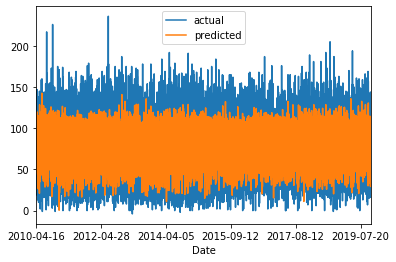

In [22]:
df_all_players_predicted = df_predicted_scores[['Date', 'actual', 'predicted']]
df_all_players_predicted = df_all_players_predicted.set_index('Date')
lines = df_all_players_predicted.plot.line()

### View and plot the predictions for a specific player... Patrick Dangerfield!

,actual,predicted
Date,,
2010-05-23,85,72.143146
2010-06-05,118,70.905397
2010-08-01,50,79.641609
2010-08-21,46,68.914275
2010-08-28,53,74.362695
...,...,...
2019-06-07,149,105.119459
2019-06-22,141,107.088052
2019-08-03,57,113.735803


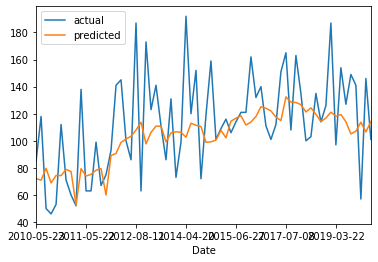

In [23]:
df_player = df_predicted_scores.loc[df_predicted_scores['Player'] == 'Patrick Dangerfield']
df_player = df_player[['Date', 'actual', 'predicted']]
df_player = df_player.set_index('Date')
display(df_player)
lines = df_player.plot.line()

### Let's compare the prediction against some benchmarks
The model is approximately 10% better at predicting a player's Supercoach score than the typically used method (yearly average). 

We can also see that as rolling average decreases, the error rate increases. 

This is good!

In [24]:
# Is it a better predictor than simply 20, 10, 5, 3, or 1 round average? YES

from sklearn.metrics import mean_squared_error 

display(mean_squared_error(df_predicted_scores['rolling 20 round average'], df_predicted_scores['actual']))
display(mean_squared_error(df_predicted_scores['rolling 10 round average'], df_predicted_scores['actual']))
display(mean_squared_error(df_predicted_scores['rolling 5 round average'], df_predicted_scores['actual']))
display(mean_squared_error(df_predicted_scores['rolling 3 round average'], df_predicted_scores['actual']))
display(mean_squared_error(df_predicted_scores['previous sc score'], df_predicted_scores['actual']))
display('')
display(mean_squared_error(df_predicted_scores['predicted'], df_predicted_scores['actual']))

651.1127401542527

658.3329369348382

698.8501665977578

758.7893135392844

1100.0149230590332

''

582.967504984807